In [1]:
import h5py
import os
import glob
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import statsmodels
pd.set_option('display.max_columns', 2000)  # or 1000
pd.set_option('display.max_rows', 2000)  # or 1000

import pylab as pl
import numpy as np
import scipy.stats as stats
def findOccurrences(s, ch):
    return [i for i, letter in enumerate(s) if letter == ch]

/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [28]:
all_session_list = ['20190909_JC110','20190911_JC110','20190913_JC110','20190916_JC110',\
                    '20190918_JC110','20190920_JC110','20190925_JC110','20190930_JC110',\
                    '20191003_JC110','20190927_JC111','20191002_JC111','20191004_JC111',\
                   '20191016_JC113','20191019_JC113','20191021_JC113','20191023_JC113',\
                   '20191025_JC113','20191029_JC113','20191101_JC113','20191106_JC113',\
                   '20191024_JC117','20191028_JC117','20191030_JC117','20191107_JC117',\
                   '20191118_JC117','20191115_JC120','20191116_JC120','20191124_JC120',\
                   '20191125_JC120','20191126_JC120','20191127_JC120','20191119_JC121',\
                   '20190619_JC080','20190624_JC085','20190704_JC085','20190712_JC085',\
                   '20190621_JC091','20190625_JC091','20190701_JC091','20190703_JC091',\
                   '20190705_JC091','20190621_JC097','20190628_JC097','20190702_JC097',\
                   '20190704_JC097','20190708_JC097']

# all_session_list = ['20190909_JC110','20190911_JC110']



#''
class struct: pass
opts = struct()
opts = struct()
#opts.rootdir = '/Volumes/coxfs01/2p-data'
opts.rootdir = '/n/coxfs01/2p-data'
opts.acquisition = 'FOV1_zoom4p0x'
opts.traceid = 'traces102'
opts.combined_run = 'scenes_combined'
dst_root = '/n/coxfs01/cechavarria/2p-aggregate/scenes'
traceid = '%s_s2p'%(opts.traceid)
cond_labels = ['Original','Medium','Low']

qval_thresh = 1e-2#using adjusted p-values
resp_type = 'mean_response'#mean_response or max_response
data_type = 'global_df_f'#'dspks'#'global_df_f'

In [29]:
cum_idx = 0
all_sess_df = []

sess_idx = 0
sess = all_session_list[sess_idx]

for sess_idx, sess in enumerate(all_session_list):

    print(sess)

    i1 = findOccurrences(sess,'_')[0]

    opts.animalid = sess[i1+1:]
    opts.session = sess[0:i1]

    #% Set up source paths:    
    acquisition_dir = os.path.join(opts.rootdir, opts.animalid, opts.session, opts.acquisition)
    responses_dir = os.path.join(acquisition_dir, opts.combined_run,'responses',traceid)
    src_file_dir = os.path.join(responses_dir, 'files')


    #*get label file*
    label_fn = 'area_cell_labels.npz'
    label_filepath = os.path.join(src_file_dir, label_fn)
    label_grp = np.load(label_filepath)

    label_list = label_grp['label_list']
    label_grp.close()

    #*get fdr file*
    fdr_fn = 'pval_fdr_corrected_%s_%s_arrays.hdf5'%(resp_type,data_type)
    fdr_filepath = os.path.join(src_file_dir, fdr_fn)
    fdr_grp = h5py.File(fdr_filepath, 'r')
    ntrials = fdr_grp.attrs['num_trials']

    contrast_sign = np.array(fdr_grp['contrast_sign'])
    qvals = np.array(fdr_grp['fdr_pval'])
    nrois = qvals.shape[0]
 



    #consider active if null hypothesis rejected and greater than baseline
    active_cfgs = np.logical_and(contrast_sign>0,qvals<qval_thresh)

    active_unit = np.array([np.any(active_cfgs[ridx,:]) for ridx in range(nrois)])


    #*Getting Active Cells from Retinotopy

    retino_traceid_dir = os.path.join(acquisition_dir, 'retino_combined', 'traces',traceid)
    retino_file_dir = os.path.join(retino_traceid_dir,'retino_analysis','files')

    #load combo file

    combo_grp = h5py.File(os.path.join(retino_file_dir,'combined_retino_data.hdf5'), 'r')

    cell_rois = np.array(combo_grp.attrs['s2p_cell_rois'])

    stim_type = ['right','top','left','bottom']#just hard-code all stim types

    #current_stimulus = stim_type[0]
    for count,current_stimulus in enumerate(stim_type):
        curr_slice = 'Slice01'
        #retrieve mag ratio values
        combo_mag_ratio = combo_grp[current_stimulus][curr_slice]['mag_ratio_array'][:]

        #aggregate mag ratio values
        if count == 0:
            all_mag_ratio = combo_mag_ratio
        else:
            all_mag_ratio = np.vstack((all_mag_ratio,combo_mag_ratio))
    combo_grp.close()
    max_mag_ratio = np.max(all_mag_ratio,0)
    std_thresh = .01
    retino_active_unit = max_mag_ratio>std_thresh
    
    #keep track of units activated by both
    both_active_unit = np.logical_and(active_unit,retino_active_unit)



    #if multiple areas break down by area covered

    #area = np.unique(label_list)[0]
    for area in np.unique(label_list):
        print('---- %s -----'% area)
        area_idxs = np.where(label_list==area)[0]

        active_unit_area = active_unit[area_idxs]
        active_unit_count = np.sum(active_unit_area)
        active_unit_frac = active_unit_count/float(area_idxs.size)

        print('Total Units: %i'%active_unit_area.size)
        print('*Scene Activity*')
        print('Number Active: %i'%active_unit_count)
        print'Fraction Active: %.03f'%(active_unit_frac)



        retino_active_count = np.sum(retino_active_unit[area_idxs])
        retino_active_frac = retino_active_count/float(area_idxs.size)
        print('*Retinotopy Activity*')
        print('Number of active cells:%i'%retino_active_count)
        print('Fraction of active cells:%.03f'%retino_active_frac)
        
  
        both_active_count = np.sum(both_active_unit[area_idxs])
        both_active_frac = both_active_count/float(area_idxs.size)
        
        print('*Activity for Both Experiments*')
        print('Number of active cells:%i'%both_active_count)
        print('Fraction of active cells:%.03f'%both_active_frac)





        #Put values into dataframe
        sess_df = pd.DataFrame({'AnimalID':opts.animalid,'Session':opts.session,'Area':area,\
                                'Cell Count':area_idxs.size,'All FOV Count':len(cell_rois),\
                                'Kind':'Scenes','Num Trials':ntrials,\
                                'Active Count':active_unit_count,\
                                'Active Fraction': active_unit_frac},[3*sess_idx])


        all_sess_df.append(sess_df)
        
        sess_df = pd.DataFrame({'AnimalID':opts.animalid,'Session':opts.session,'Area':area,\
                     'Cell Count':area_idxs.size,'Kind': 'Retino',\
                     'Active Count': retino_active_count,
                     'Active Fraction': retino_active_frac},[(3*sess_idx)+1])
        all_sess_df.append(sess_df)
        
        sess_df = pd.DataFrame({'AnimalID':opts.animalid,'Session':opts.session,'Area':area,\
                     'Cell Count':area_idxs.size,'Kind': 'Both',\
                     'Active Count': both_active_count,
                     'Active Fraction': both_active_frac},[(3*sess_idx)+2])
        all_sess_df.append(sess_df)
        
all_sess_df = pd.concat(all_sess_df, axis = 0)

20190909_JC110
---- V1 -----
Total Units: 115
*Scene Activity*
Number Active: 73
Fraction Active: 0.635
*Retinotopy Activity*
Number of active cells:78
Fraction of active cells:0.678
*Activity for Both Experiments*
Number of active cells:49
Fraction of active cells:0.426
20190911_JC110
---- LM -----
Total Units: 128
*Scene Activity*
Number Active: 58
Fraction Active: 0.453
*Retinotopy Activity*
Number of active cells:61
Fraction of active cells:0.477
*Activity for Both Experiments*
Number of active cells:31
Fraction of active cells:0.242
---- V1/LM -----
Total Units: 48
*Scene Activity*
Number Active: 16
Fraction Active: 0.333
*Retinotopy Activity*
Number of active cells:35
Fraction of active cells:0.729
*Activity for Both Experiments*
Number of active cells:12
Fraction of active cells:0.250
20190913_JC110
---- V1 -----
Total Units: 180
*Scene Activity*
Number Active: 103
Fraction Active: 0.572
*Retinotopy Activity*
Number of active cells:94
Fraction of active cells:0.522
*Activity for

In [30]:
#----- SUMMARY FIGURES ------------

summary_df = []
for stim_type in ['Retino','Scenes','Both']:
    print(stim_type)
    all_sess_df_sub = all_sess_df.loc[all_sess_df['Kind']==stim_type]
    tmp_df = all_sess_df_sub.groupby(['Area'])
    summary_df_sub = tmp_df.sum()[['Active Count','Cell Count']].copy()
    summary_df_sub['Active Fraction'] = summary_df_sub['Active Count']/summary_df_sub['Cell Count']
    summary_df_sub['Kind'] = stim_type
    summary_df.append(summary_df_sub)
summary_df = pd.concat(summary_df, axis = 0)
summary_df['Area'] = summary_df.index
print(summary_df)


Retino
Scenes
Both
       Active Count  Cell Count  Active Fraction    Kind   Area
Area                                                           
LI              202         568         0.355634  Retino     LI
LM              649        2241         0.289603  Retino     LM
V1              948        2668         0.355322  Retino     V1
V1/LM           213         473         0.450317  Retino  V1/LM
LI              172         568         0.302817  Scenes     LI
LM              446        2241         0.199018  Scenes     LM
V1             1003        2668         0.375937  Scenes     V1
V1/LM           106         473         0.224101  Scenes  V1/LM
LI               49         568         0.086268    Both     LI
LM              164        2241         0.073182    Both     LM
V1              416        2668         0.155922    Both     V1
V1/LM            50         473         0.105708    Both  V1/LM


In [31]:

fig_out_dir = '/n/coxfs01/cechavarria/2p-aggregate/figures/cell count/'

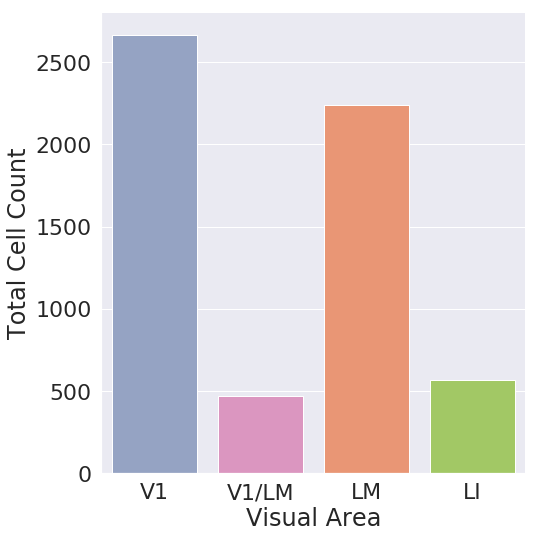

In [32]:
sns.set(font_scale = 2)
palette = sns.color_palette(["#8da0cb","#e78ac3","#fc8d62","#a6d854"])
sns.set_palette(palette)
p = sns.catplot(x = 'Area',y='Cell Count',\
            order = ['V1','V1/LM','LM','LI'],\
            kind = 'bar',data = summary_df.loc[summary_df['Kind']=='Scenes'],height = 8);
p.ax.set_xlabel('Visual Area');
p.ax.set_ylabel('Total Cell Count');

fig_fn = 'total_cell_count_all_areas.png'
fig_file_path = os.path.join(fig_out_dir, fig_fn)

p.savefig(fig_file_path)
#plt.close()

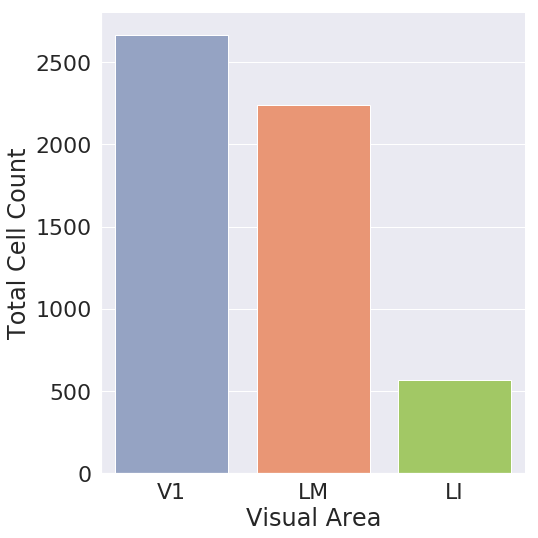

In [33]:
sns.set(font_scale = 2)
palette = sns.color_palette(["#8da0cb","#fc8d62","#a6d854"])
sns.set_palette(palette)
p = sns.catplot(x = 'Area',y='Cell Count',\
            order = ['V1','LM','LI'],\
            kind = 'bar',data = summary_df.loc[summary_df['Kind']=='Scenes'],height = 8);
p.ax.set_xlabel('Visual Area');
p.ax.set_ylabel('Total Cell Count');

fig_fn = 'total_cell_count_main_areas.png'
fig_file_path = os.path.join(fig_out_dir, fig_fn)

p.savefig(fig_file_path)
#plt.close()

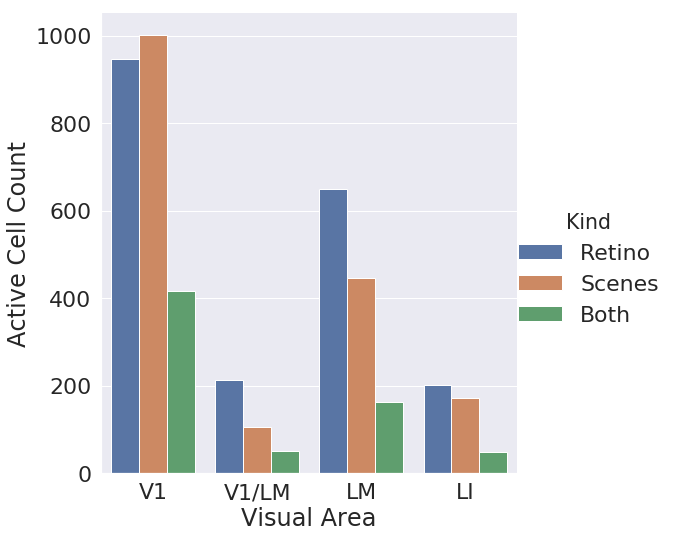

In [34]:
sns.set(font_scale = 2)
sns.set_palette(sns.color_palette("deep", 5))


p = sns.catplot(x = 'Area',y='Active Count',hue = 'Kind',\
            order = ['V1','V1/LM','LM','LI'],\
            kind = 'bar',data = summary_df,height = 8)

p.ax.set_xlabel('Visual Area');
p.ax.set_ylabel('Active Cell Count');

fig_fn = 'pooled_all_areas_active_count_qthresh_%.1E_%s_%s.png'%(qval_thresh,resp_type,data_type)
fig_file_path = os.path.join(fig_out_dir, fig_fn)

plt.savefig(fig_file_path)
#plt.close()

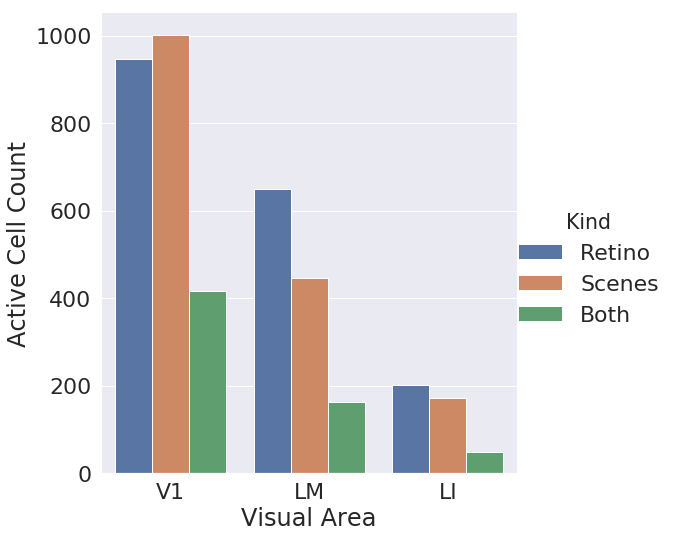

In [35]:
sns.set(font_scale = 2)
sns.set_palette(sns.color_palette("deep", 5))


p = sns.catplot(x = 'Area',y='Active Count',hue = 'Kind',\
            order = ['V1','LM','LI'],\
            kind = 'bar',data = summary_df,height = 8)

p.ax.set_xlabel('Visual Area');
p.ax.set_ylabel('Active Cell Count');

fig_fn = 'pooled_main_areas_active_count_qthresh_%.1E_%s_%s.png'%(qval_thresh,resp_type,data_type)
fig_file_path = os.path.join(fig_out_dir, fig_fn)

p.savefig(fig_file_path)
#plt.close()

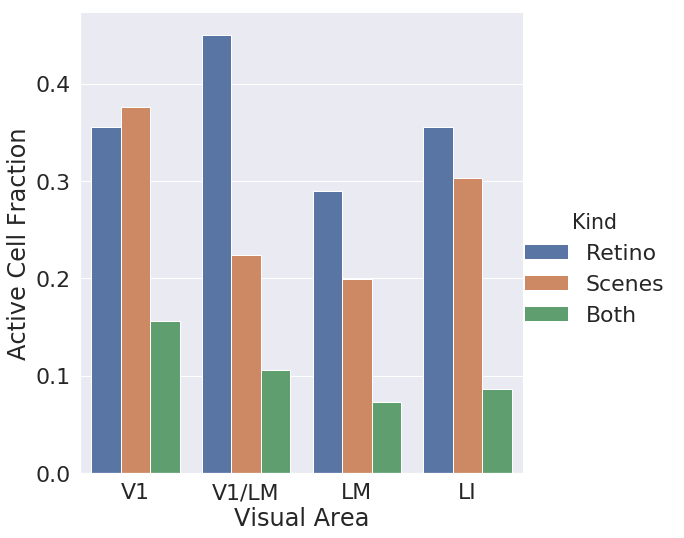

In [36]:
sns.set(font_scale = 2)
sns.set_palette(sns.color_palette("deep", 5))

p = sns.catplot(x = 'Area',y='Active Fraction',hue = 'Kind',\
            order = ['V1','V1/LM','LM','LI'],\
            kind = 'bar',data = summary_df,height = 8)

p.ax.set_xlabel('Visual Area');
p.ax.set_ylabel('Active Cell Fraction');

fig_fn = 'pooled_all_areas_active_fraction_qthresh_%.1E_%s_%s.png'%(qval_thresh,resp_type,data_type)
fig_file_path = os.path.join(fig_out_dir, fig_fn)

plt.savefig(fig_file_path)
#plt.close()

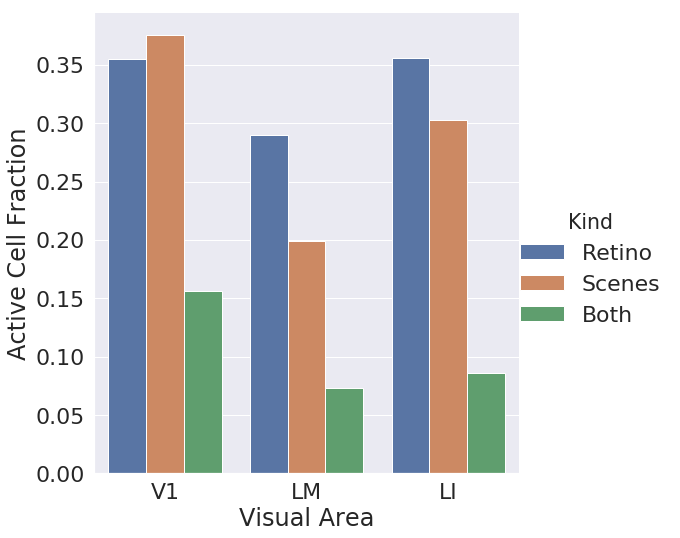

In [37]:
sns.set(font_scale = 2)
sns.set_palette(sns.color_palette("deep", 5))

p = sns.catplot(x = 'Area',y='Active Fraction',hue = 'Kind',\
            order = ['V1','LM','LI'],\
            kind = 'bar',data = summary_df,height = 8)

p.ax.set_xlabel('Visual Area');
p.ax.set_ylabel('Active Cell Fraction');

fig_fn = 'pooled_main_areas_active_fraction_qthresh_%.1E_%s_%s.png'%(qval_thresh,resp_type,data_type)
fig_file_path = os.path.join(fig_out_dir, fig_fn)

plt.savefig(fig_file_path)
#plt.close()

/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


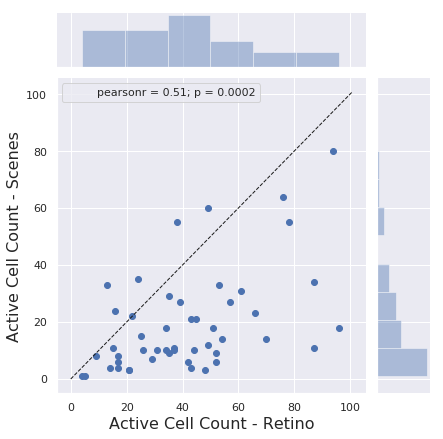

In [12]:
sns.set(font_scale = 1)


g = sns.jointplot(x = all_sess_df.loc[all_sess_df['Kind']=='Retino']['Active Count'].values,\
                y = all_sess_df.loc[all_sess_df['Kind']=='Scenes']['Active Count'].values);
g.annotate(stats.pearsonr);

g.ax_joint.set_xlabel('Active Cell Count - Retino',fontsize = 16);
g.ax_joint.set_ylabel('Active Cell Count - Scenes',fontsize = 16);

xmax = g.ax_joint.get_xlim()[1]
ymax = g.ax_joint.get_ylim()[1]
X_plot = np.linspace(0, np.max([xmax,ymax]), 100)
Y_plot = X_plot
g.ax_joint.plot(X_plot,Y_plot,'k--', linewidth=1)

fig_fn = 'session_retino_scene_corr_count_qthresh_%.1E_%s_%s.png'%(qval_thresh,resp_type,data_type)
fig_file_path = os.path.join(fig_out_dir, fig_fn)

g.savefig(fig_file_path)
#plt.close()

/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


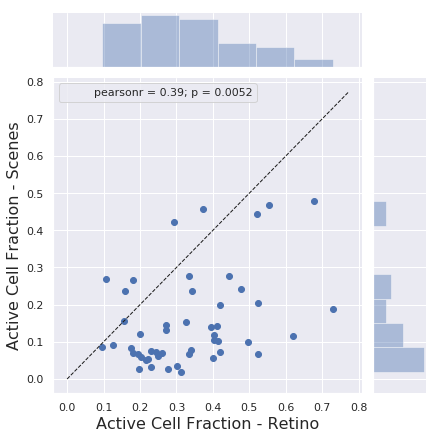

In [13]:
g = sns.jointplot(x = all_sess_df.loc[all_sess_df['Kind']=='Retino']['Active Fraction'].values,\
                y = all_sess_df.loc[all_sess_df['Kind']=='Scenes']['Active Fraction'].values);
g.annotate(stats.pearsonr);

g.ax_joint.set_xlabel('Active Cell Fraction - Retino',fontsize = 16);
g.ax_joint.set_ylabel('Active Cell Fraction - Scenes',fontsize = 16);

xmax = g.ax_joint.get_xlim()[1]
ymax = g.ax_joint.get_ylim()[1]
X_plot = np.linspace(0, np.max([xmax,ymax]), 100)
Y_plot = X_plot
g.ax_joint.plot(X_plot,Y_plot,'k--', linewidth=1)

fig_fn = 'session_retino_scene_corr_fraction_qthresh_%.1E_%s_%s.png'%(qval_thresh,resp_type,data_type)
fig_file_path = os.path.join(fig_out_dir, fig_fn)

g.savefig(fig_file_path)
#plt.close()

In [16]:
all_sess_redux_df = all_sess_df.loc[all_sess_df['Area']!='V1/LM']

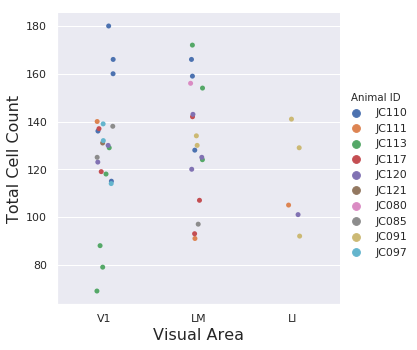

In [17]:
#plot with only V1, LM,LI
#strip showing animal by color
p = sns.catplot(x = 'Area', order = ['V1','LM','LI'],\
                y = 'Cell Count', hue = 'AnimalID',\
                kind = 'strip',\
                data = all_sess_redux_df.loc[all_sess_redux_df['Kind']=='Scenes'])


p.ax.set_xlabel('Visual Area',fontsize = 16)
p.ax.set_ylabel('Total Cell Count',fontsize = 16)
p._legend.set_title('Animal ID')



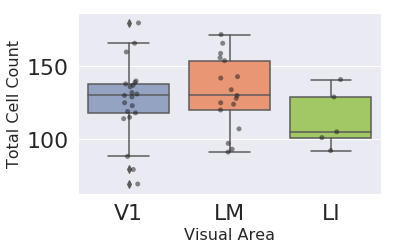

In [18]:
#plot with only V1, LM,LI
sns.set(font_scale = 2)
fig, ax = plt.subplots(1,1)

#boxplot with individual points
sns.boxplot(x = 'Area', order = ['V1','LM','LI'],\
                y = 'Cell Count', \
                data = all_sess_redux_df.loc[all_sess_redux_df['Kind']=='Scenes'],ax=ax,\
        palette = ["#8da0cb","#fc8d62","#a6d854"])

sns.stripplot(x = 'Area', order = ['V1','LM','LI'],\
                y = 'Cell Count', \
                data = all_sess_redux_df.loc[all_sess_redux_df['Kind']=='Scenes'],color = 'k',\
              alpha = 0.5,ax = ax)



ax.set_xlabel('Visual Area',fontsize = 16);
ax.set_ylabel('Total Cell Count',fontsize = 16);

fig_fn = 'per_sess_main_areas_total_count_thresh.png'
fig_file_path = os.path.join(fig_out_dir, fig_fn)
plt.tight_layout()
fig.savefig(fig_file_path)
#plt.close()

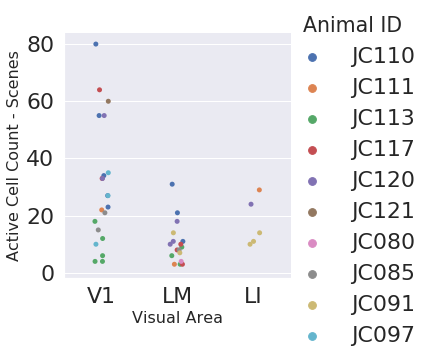

In [19]:
p = sns.catplot(x = 'Area', order = ['V1','LM','LI'],\
                y = 'Active Count', hue = 'AnimalID',\
                kind = 'strip',\
                data = all_sess_redux_df.loc[all_sess_redux_df['Kind']=='Scenes'])


p.ax.set_xlabel('Visual Area',fontsize = 16)
p.ax.set_ylabel('Active Cell Count - Scenes',fontsize = 16)
p._legend.set_title('Animal ID')

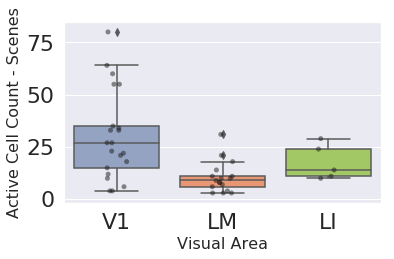

In [20]:
sns.set(font_scale = 2)
fig, ax = plt.subplots(1,1)

#boxplot with individual points
sns.boxplot(x = 'Area', order = ['V1','LM','LI'],\
                y = 'Active Count', \
                data = all_sess_redux_df.loc[all_sess_redux_df['Kind']=='Scenes'],ax=ax,\
           palette = ["#8da0cb","#fc8d62","#a6d854"])

sns.stripplot(x = 'Area', order = ['V1','LM','LI'],\
                y = 'Active Count', \
                data = all_sess_redux_df.loc[all_sess_redux_df['Kind']=='Scenes'],color = 'k',alpha = 0.5,ax = ax)



ax.set_xlabel('Visual Area',fontsize = 16);
ax.set_ylabel('Active Cell Count - Scenes',fontsize = 16);

fig_fn = 'per_sess_main_areas_active_count_qthresh_%.1E_%s_%s.png'%(qval_thresh,resp_type,data_type)
fig_file_path = os.path.join(fig_out_dir, fig_fn)

plt.tight_layout()
fig.savefig(fig_file_path)
#plt.close()

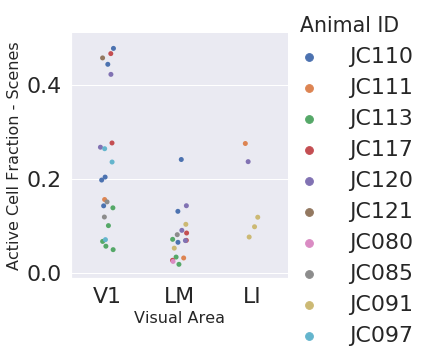

In [21]:
p = sns.catplot(x = 'Area', order = ['V1','LM','LI'],\
                y = 'Active Fraction', hue = 'AnimalID',\
                kind = 'strip',\
                data = all_sess_redux_df.loc[all_sess_redux_df['Kind']=='Scenes'])


p.ax.set_xlabel('Visual Area',fontsize = 16)
p.ax.set_ylabel('Active Cell Fraction - Scenes',fontsize = 16)
p._legend.set_title('Animal ID')

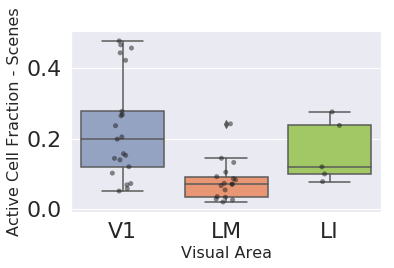

In [22]:
sns.set(font_scale = 2)
fig, ax = plt.subplots(1,1)

#boxplot with individual points
sns.boxplot(x = 'Area', order = ['V1','LM','LI'],\
                y = 'Active Fraction', \
                data = all_sess_redux_df.loc[all_sess_redux_df['Kind']=='Scenes'],ax=ax,\
           palette = ["#8da0cb","#fc8d62","#a6d854"])

sns.stripplot(x = 'Area', order = ['V1','LM','LI'],\
                y = 'Active Fraction', \
                data = all_sess_redux_df.loc[all_sess_redux_df['Kind']=='Scenes'],color = 'k',alpha = 0.5,ax = ax)



ax.set_xlabel('Visual Area',fontsize = 16);
ax.set_ylabel('Active Cell Fraction - Scenes',fontsize = 16);

fig_fn = 'per_sess_main_areas_active_fraction_qthresh_%.1E_%s_%s.png'%(qval_thresh,resp_type,data_type)
fig_file_path = os.path.join(fig_out_dir, fig_fn)

plt.tight_layout()
fig.savefig(fig_file_path)
#plt.close()

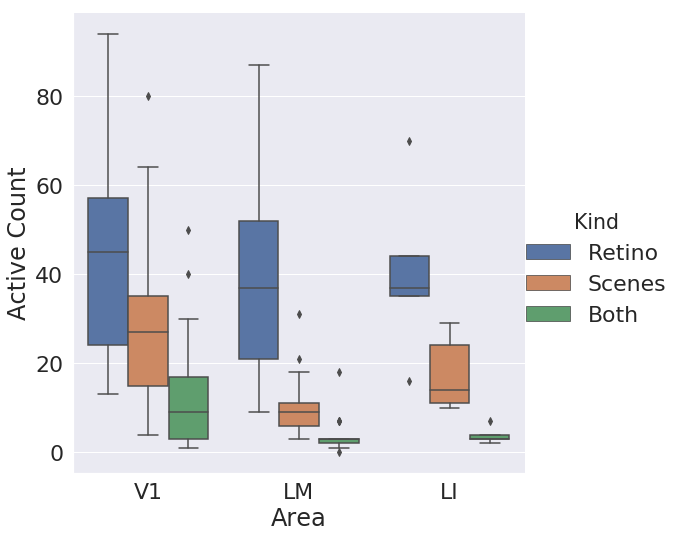

In [23]:
sns.catplot(x = 'Area', order = ['V1','LM','LI'], hue = 'Kind' ,\
            y = 'Active Count',kind = 'box',data = all_sess_redux_df,height = 8,hue_order = ['Retino','Scenes','Both'])
ax.set_xlabel('Visual Area',fontsize = 16);
ax.set_ylabel('Active Cell Count',fontsize = 16);

fig_fn = 'per_sess_main_areas_active_count_box_by_kind_qthresh_%.1E_%s_%s.png'\
%(qval_thresh,resp_type,data_type)
fig_file_path = os.path.join(fig_out_dir, fig_fn)

plt.savefig(fig_file_path)
#plt.close()

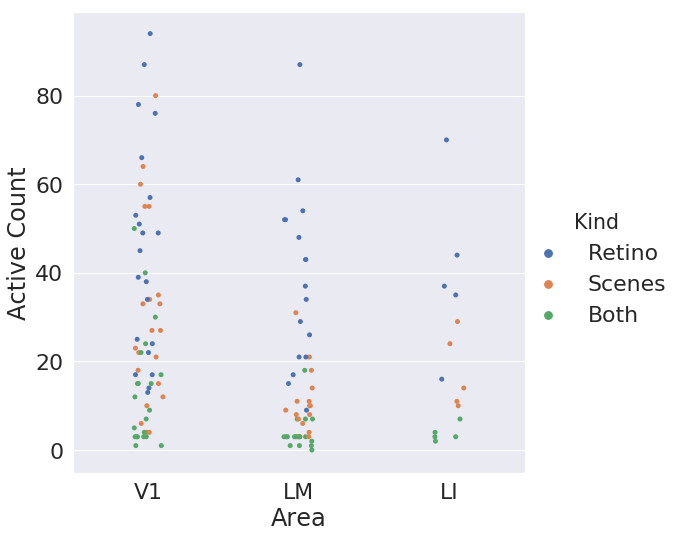

In [24]:
sns.catplot(x = 'Area', order = ['V1','LM','LI'], hue = 'Kind' ,\
            y = 'Active Count',kind = 'strip',data = all_sess_redux_df,height = 8,\
            hue_order = ['Retino','Scenes','Both'])
ax.set_xlabel('Visual Area',fontsize = 16);
ax.set_ylabel('Active Cell Count',fontsize = 16);

fig_fn = 'per_sess_main_areas_active_count_strip_by_kind_qthresh_%.1E_%s_%s.png'\
%(qval_thresh,resp_type,data_type)
fig_file_path = os.path.join(fig_out_dir, fig_fn)

plt.savefig(fig_file_path)
#plt.close()

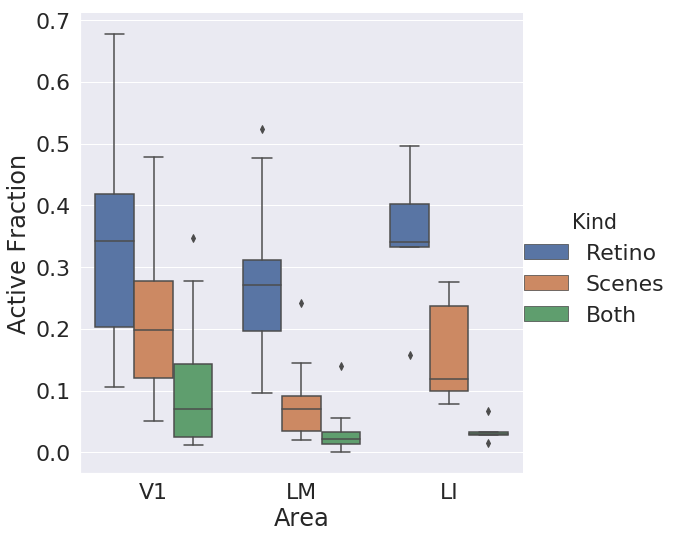

In [25]:
sns.catplot(x = 'Area', order = ['V1','LM','LI'], hue = 'Kind' ,\
            y = 'Active Fraction',kind = 'box',data = all_sess_redux_df,height = 8,hue_order = ['Retino','Scenes','Both'])
ax.set_xlabel('Visual Area',fontsize = 16);
ax.set_ylabel('Active Cell Fraction',fontsize = 16);

fig_fn = 'per_sess_main_areas_active_fraction_box_by_kind_thresh_%.1E_%s_%s.png'\
%(qval_thresh,resp_type,data_type)
fig_file_path = os.path.join(fig_out_dir, fig_fn)

plt.savefig(fig_file_path)
#plt.close()

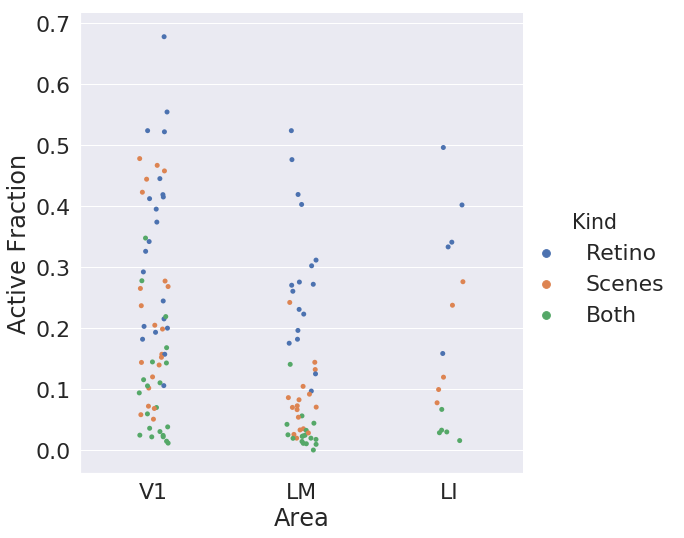

In [25]:
sns.catplot(x = 'Area', order = ['V1','LM','LI'], hue = 'Kind' ,\
            y = 'Active Fraction',kind = 'strip',data = all_sess_redux_df,height = 8,hue_order = ['Retino','Scenes','Both'])
ax.set_xlabel('Visual Area',fontsize = 16);
ax.set_ylabel('Active Cell Fraction',fontsize = 16);

fig_fn = 'per_sess_main_areas_active_fraction_strip_by_kind_qthresh_%.1E_%s_%s.png'\
%(qval_thresh,resp_type,data_type)
fig_file_path = os.path.join(fig_out_dir, fig_fn)

plt.savefig(fig_file_path)
#plt.close()

/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


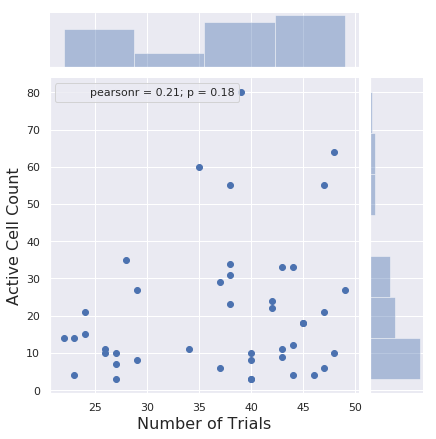

In [26]:
sns.set(font_scale = 1)


g = sns.jointplot(x = all_sess_redux_df.loc[all_sess_redux_df['Kind']=='Scenes']['Num Trials'].values,
                y = all_sess_redux_df.loc[all_sess_redux_df['Kind']=='Scenes']['Active Count'].values)
g.annotate(stats.pearsonr);

g.ax_joint.set_xlabel('Number of Trials',fontsize = 16);
g.ax_joint.set_ylabel('Active Cell Count',fontsize = 16);

fig_fn = 'session_trial_count_active_count_qthres_%.1E_%s_%s.png'%(qval_thresh,resp_type,data_type)
fig_file_path = os.path.join(fig_out_dir, fig_fn)

g.savefig(fig_file_path)

/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


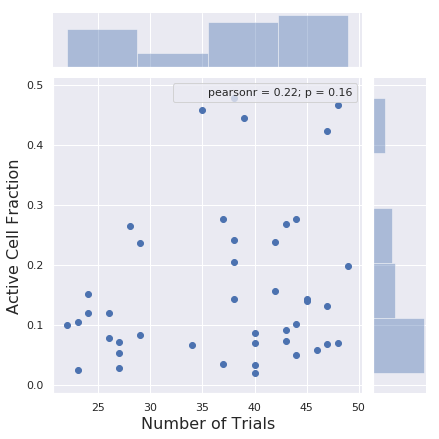

In [27]:
sns.set(font_scale = 1)


g = sns.jointplot(x = all_sess_redux_df.loc[all_sess_redux_df['Kind']=='Scenes']['Num Trials'].values,
                y = all_sess_redux_df.loc[all_sess_redux_df['Kind']=='Scenes']['Active Fraction'].values)
g.annotate(stats.pearsonr);

g.ax_joint.set_xlabel('Number of Trials',fontsize = 16);
g.ax_joint.set_ylabel('Active Cell Fraction',fontsize = 16);

fig_fn = 'session_trial_count_active_fraction_qthrtesh_%.1E_%s_%s.png'%(qval_thresh,resp_type,data_type)
fig_file_path = os.path.join(fig_out_dir, fig_fn)

g.savefig(fig_file_path)

In [ ]:
fig, ax = plt.subplots(1,1)

#boxplot with individual points
sns.boxplot(x = 'Area', order = ['V1','V1/LM','LM','LI'],\
                y = 'Cell Count', \
                data = all_sess_major_df.loc[all_sess_major_df['Kind']=='Scenes'],ax=ax)

sns.stripplot(x = 'Area', order = ['V1','V1/LM','LM','LI'],\
                y = 'Cell Count', \
                data = all_sess_major_df.loc[all_sess_major_df['Kind']=='Scenes'],color = 'k',alpha = 0.5,ax = ax)



ax.set_xlabel('Visual Area',fontsize = 16);
ax.set_ylabel('Total Cell Count',fontsize = 16);

In [ ]:
fig, ax = plt.subplots(1,1)

#boxplot with individual points
sns.boxplot(x = 'Area', order = ['V1','V1/LM','LM','LI'],\
                y = 'Active Fraction', \
                data = all_sess_major_df.loc[all_sess_major_df['Kind']=='Scenes'],ax=ax)

sns.stripplot(x = 'Area', order = ['V1','V1/LM','LM','LI'],\
                y = 'Active Fraction', \
                data = all_sess_major_df.loc[all_sess_major_df['Kind']=='Scenes'],color = 'k',alpha = 0.5,ax = ax)



ax.set_xlabel('Visual Area',fontsize = 16);
ax.set_ylabel('Active Cell Fraction - Scenes',fontsize = 16);

In [ ]:
sns.catplot(x = 'Area', order = ['V1','V1/LM','LM','LI'], hue = 'Kind' ,\
            y = 'Active Fraction',kind = 'box',data = all_sess_major_df)
ax.set_xlabel('Visual Area',fontsize = 16);
ax.set_ylabel('Active Cell Fraction',fontsize = 16);

In [ ]:
sns.catplot(x = 'Area', order = ['V1','V1/LM','LM','LI'], hue = 'Kind' ,\
            y = 'Active Fraction',kind = 'strip',data = all_sess_major_df)
ax.set_xlabel('Visual Area',fontsize = 16);
ax.set_ylabel('Active Cell Fraction',fontsize = 16);

In [ ]:
#plots with all sub-paritions of FOVs
fig, ax = plt.subplots(1,1)

#boxplot with individual points
sns.boxplot(x = 'Area', order = ['V1','V1/LM','LM','LI'],\
                y = 'Cell Count', \
                data = all_sess_df.loc[all_sess_df['Kind']=='Scenes'],ax=ax)

sns.stripplot(x = 'Area', order = ['V1','V1/LM','LM','LI'],\
                y = 'Cell Count', \
                data = all_sess_df.loc[all_sess_df['Kind']=='Scenes'],color = 'k',alpha = 0.5,ax = ax)



ax.set_xlabel('Visual Area',fontsize = 16);
ax.set_ylabel('Total Cell Count',fontsize = 16);

In [ ]:

#boxplot with individual points
p = sns.catplot(x = 'Area', order = ['V1','V1/LM','LM','LI'],\
                y = 'Active Fraction', hue = 'AnimalID',\
                kind = 'strip',\
                data = all_sess_df.loc[all_sess_df['Kind']=='Scenes'])


ax.set_xlabel('Visual Area',fontsize = 16);
ax.set_ylabel('Active Cell Fraction - Scenes',fontsize = 16);

In [ ]:
fig, ax = plt.subplots(1,1)

#boxplot with individual points
sns.boxplot(x = 'Area', order = ['V1','V1/LM','LM','LI'],\
                y = 'Active Fraction', \
                data = all_sess_df.loc[all_sess_df['Kind']=='Scenes'],ax=ax)

sns.stripplot(x = 'Area', order = ['V1','V1/LM','LM','LI'],\
                y = 'Active Fraction', \
                data = all_sess_df.loc[all_sess_df['Kind']=='Scenes'],color = 'k',alpha = 0.5,ax = ax)



ax.set_xlabel('Visual Area',fontsize = 16);
ax.set_ylabel('Active Cell Fraction - Scenes',fontsize = 16);

In [ ]:
p = sns.catplot(x = 'Area', order = ['V1','V1/LM','LM','LI'],\
                y = 'Cell Count', hue = 'AnimalID',\
                kind = 'strip',\
                data = all_sess_df)


p.set(xlabel='Visual Area', ylabel='Total Cell Count')
p._legend.set_title('Animal ID')

In [44]:
n = 10

u1_list = np.empty((1000,))
u2_list = np.empty((1000,))
u3_list = np.empty((1000,))
u4_list = np.empty((1000,))

for rep in range(1000):#loop de 1000 veces
    #bernoulli
    X = np.random.binomial(1,0.7,n)
    #estimators
    u1 = sum(X)/float(n)
    u2 = (sum(X)+1)/float(n)
    u3 = 0.69 + (1/float(n))
    u4 = X[n-1]
    #guardando en una lista
    u1_list[rep] = u1
    u2_list[rep] = u2
    u3_list[rep] = u3
    u4_list[rep] = u4
    
    

In [46]:
bias_u4 = bias_function(u4_list)

array([1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0.,
       1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 1., 1., 0., 1.

In [31]:
print(X)

[1 1 1 0 1 1 1 0 1 1]
